In [1]:
import anndata as ad
import squidpy as sq
import cellcharter as cc
import pandas as pd
import scanpy as sc
import scvi
import numpy as np
import matplotlib.pyplot as plt
import tqdm as notebook_tqdm

/home/xu262605/anaconda3/envs/cellcharter/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 0


In [2]:
path = '/work/rwth1209/projects/Merfish_QC/500_kidney_26.2/preprocessed.h5ad'

In [3]:
adata = sc.read_h5ad(f"{path}")
adata

AnnData object with n_obs × n_vars = 410533 × 500
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'Cellbound2_raw', 'Cellbound2_high_pass', 'COLIII_raw', 'COLIII_high_pass', 'VIM_raw', 'VIM_high_pass', 'Cellbound3_raw', 'Cellbound3_high_pass', 'PolyT_raw', 'PolyT_high_pass', 'Cellbound1_raw', 'Cellbound1_high_pass', 'Anti-Human_raw', 'Anti-Human_high_pass', 'Beta-3-Tubulin_raw', 'Beta-3-Tubulin_high_pass', 'VCAM1_raw', 'VCAM1_high_pass', 'MPO_raw', 'MPO_high_pass', 'DAPI_raw', 'DAPI_high_pass', 'region', 'slide', 'dataset_id', 'cells_region', 'EntityID', 'n_counts', 'tacco', 'tacco_score'
    uns: 'spatialdata_attrs'
    obsm: 'blank', 'spatial', 'tacco'

In [ ]:
#because adata.uns was not defined
adata.uns['spatial'] = {'library': {'metadata': {}}}

In [4]:
sc.pp.filter_cells(adata, min_counts=1)

In [5]:
adata

AnnData object with n_obs × n_vars = 410533 × 500
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'Cellbound2_raw', 'Cellbound2_high_pass', 'COLIII_raw', 'COLIII_high_pass', 'VIM_raw', 'VIM_high_pass', 'Cellbound3_raw', 'Cellbound3_high_pass', 'PolyT_raw', 'PolyT_high_pass', 'Cellbound1_raw', 'Cellbound1_high_pass', 'Anti-Human_raw', 'Anti-Human_high_pass', 'Beta-3-Tubulin_raw', 'Beta-3-Tubulin_high_pass', 'VCAM1_raw', 'VCAM1_high_pass', 'MPO_raw', 'MPO_high_pass', 'DAPI_raw', 'DAPI_high_pass', 'region', 'slide', 'dataset_id', 'cells_region', 'EntityID', 'n_counts', 'tacco', 'tacco_score'
    uns: 'spatialdata_attrs'
    obsm: 'blank', 'spatial', 'tacco'

In [9]:
adata.obs['region']

EntityID
1527444000013100017    region_0
1527444000013100026    region_0
1527444000013100032    region_0
1527444000013100033    region_0
1527444000013100034    region_0
                         ...   
1527444000560200193    region_0
1527444000560200194    region_0
1527444000560200196    region_0
1527444000560200208    region_0
1527444000560200226    region_0
Name: region, Length: 410533, dtype: category
Categories (1, object): ['region_0']

In [8]:
adata.X.max()

313.0

In [10]:
scvi.settings.seed = 12345
scvi.model.SCVI.setup_anndata(
    adata, batch_key='region')

Global seed set to 12345
/home/xu262605/anaconda3/envs/cellcharter/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [11]:
model = scvi.model.SCVI(adata)

In [12]:
model.train(early_stopping=True, enable_progress_bar=True)

/home/xu262605/anaconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/xu262605/anaconda3/envs/cellcharter/lib/python ...
  rank_zero_warn(
/home/xu262605/anaconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/xu262605/anaconda3/envs/cellcharter/lib/python ...
  rank_zero_warn(


Epoch 19/19: 100%|██████████| 19/19 [16:38<00:00, 52.56s/it, loss=61.6, v_num=1]


In [13]:
adata.obsm['X_scVI'] = model.get_latent_representation(adata).astype(np.float32)

In [14]:
sq.gr.spatial_neighbors(adata, coord_type='generic', delaunay=True, spatial_key='spatial')
cc.gr.remove_long_links(adata)

In [15]:
cc.gr.aggregate_neighbors(adata, n_layers=3, use_rep='X_scVI', out_key='X_cellcharter')

100%|██████████| 4/4 [00:01<00:00,  2.62it/s]


In [16]:
gmm = cc.tl.Cluster(n_clusters=5, random_state=12345)

In [17]:
gmm.fit(adata, use_rep='X_cellcharter')
adata.obs['spatial_cluster_5'] = gmm.predict(adata, use_rep='X_cellcharter')

/home/xu262605/anaconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/xu262605/anaconda3/envs/cellcharter/lib/python ...
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]


In [25]:
adata

AnnData object with n_obs × n_vars = 410533 × 500
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'Cellbound2_raw', 'Cellbound2_high_pass', 'COLIII_raw', 'COLIII_high_pass', 'VIM_raw', 'VIM_high_pass', 'Cellbound3_raw', 'Cellbound3_high_pass', 'PolyT_raw', 'PolyT_high_pass', 'Cellbound1_raw', 'Cellbound1_high_pass', 'Anti-Human_raw', 'Anti-Human_high_pass', 'Beta-3-Tubulin_raw', 'Beta-3-Tubulin_high_pass', 'VCAM1_raw', 'VCAM1_high_pass', 'MPO_raw', 'MPO_high_pass', 'DAPI_raw', 'DAPI_high_pass', 'region', 'slide', 'dataset_id', 'cells_region', 'EntityID', 'n_counts', 'tacco', 'tacco_score', '_scvi_batch', '_scvi_labels', 'spatial_cluster_5'
    uns: 'spatialdata_attrs', '_scvi_uuid', '_scvi_manager_uuid', 'spatial_neighbors', '_cellcharter', 'spatial_cluster_5_colors', 'spatial'
    obsm: 'blank', 'spatial', 'tacco', 'X_scVI', 'X_cellcharter'
    obsp: 'spatial_connectivities', 's

/home/xu262605/anaconda3/envs/cellcharter/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)


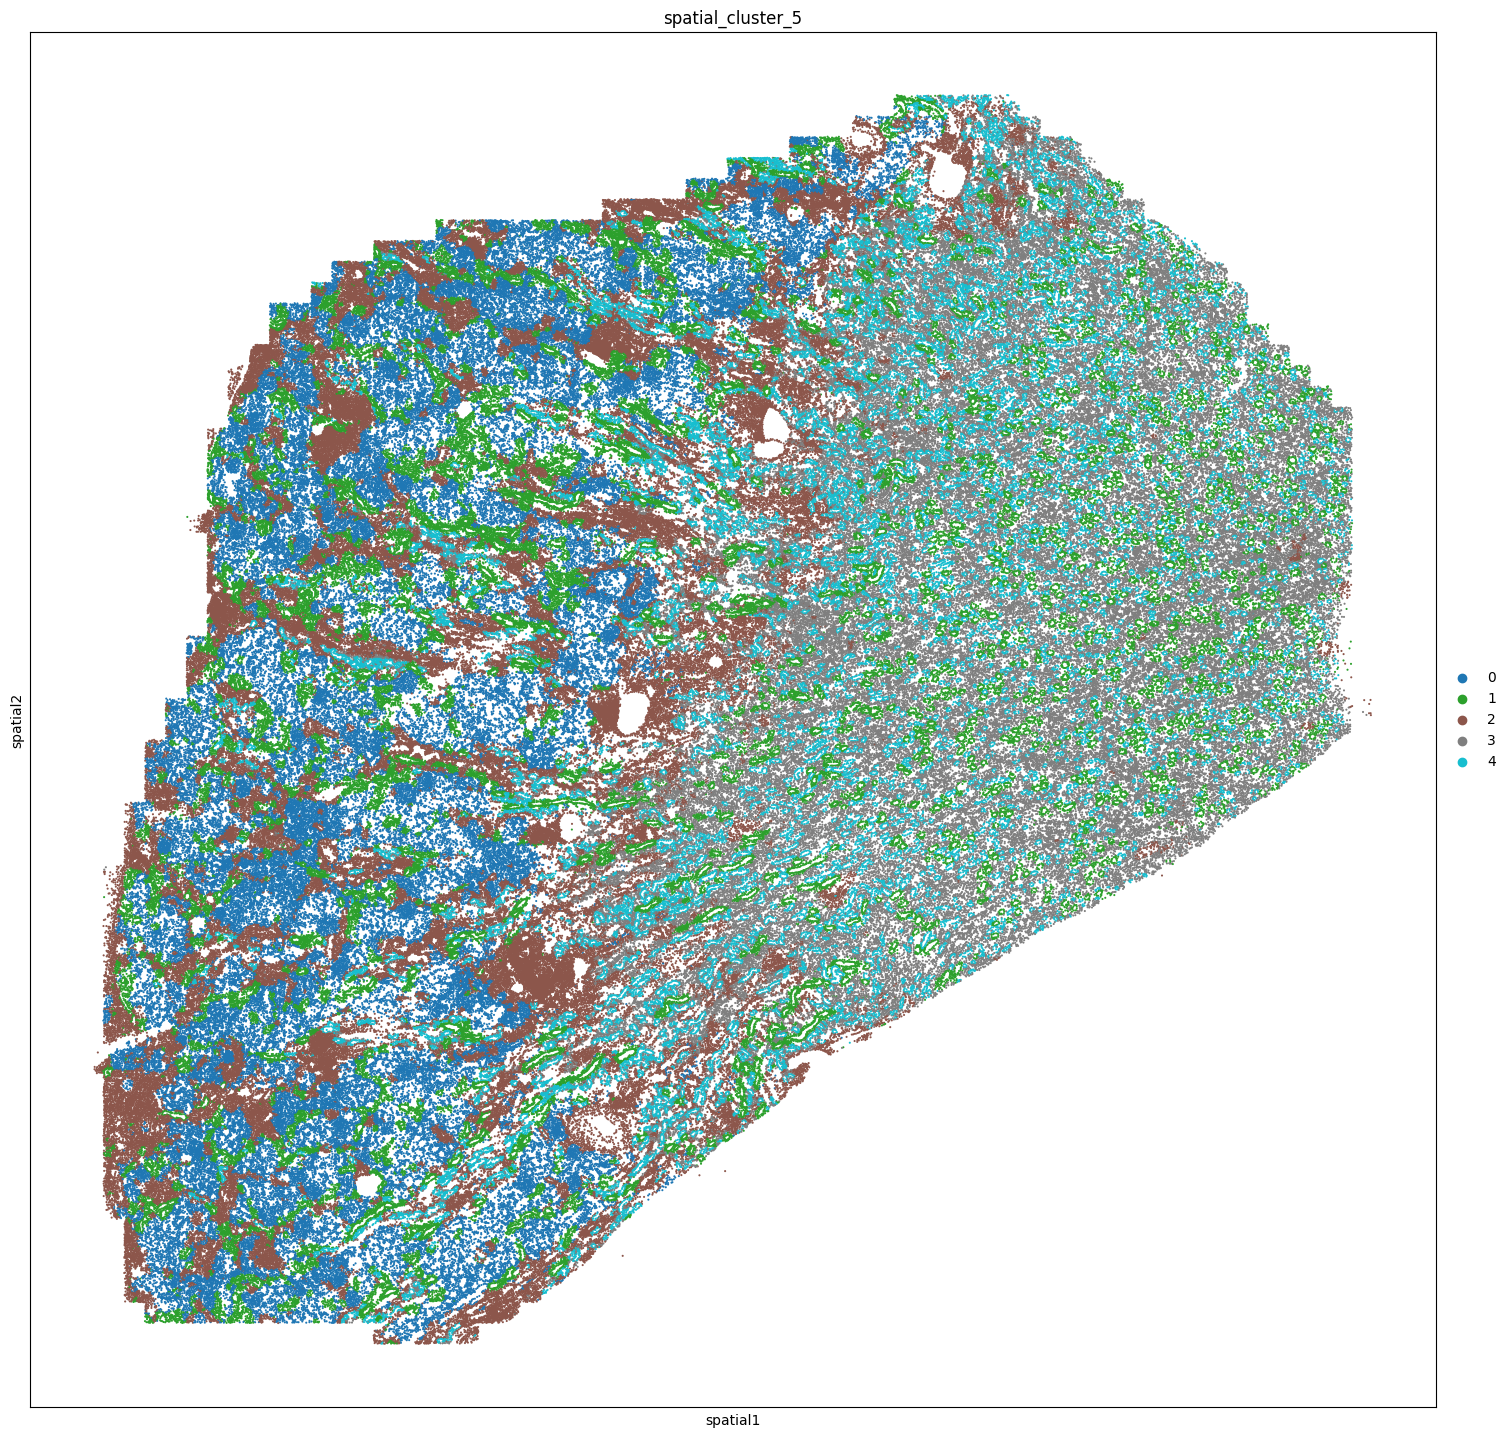

In [33]:
sq.pl.spatial_scatter(
    adata, 
    color=['spatial_cluster_5'], 
    #library_key='fov',  
    size=10, 
    img=None,
    spatial_key='spatial',
    palette='tab10',
    figsize=(15,15),
    ncols=1)

/home/xu262605/anaconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/xu262605/anaconda3/envs/cellcharter/lib/python ...
  rank_zero_warn(
/home/xu262605/anaconda3/envs/cellcharter/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/home/xu262605/anaconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. 

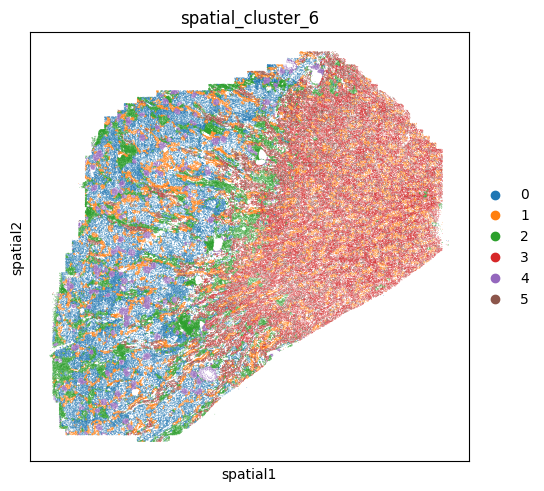

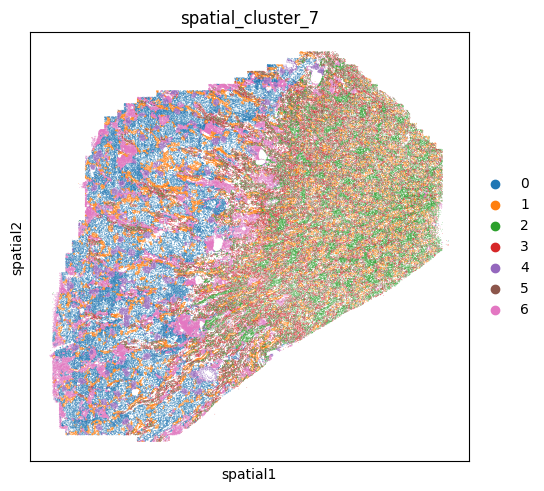

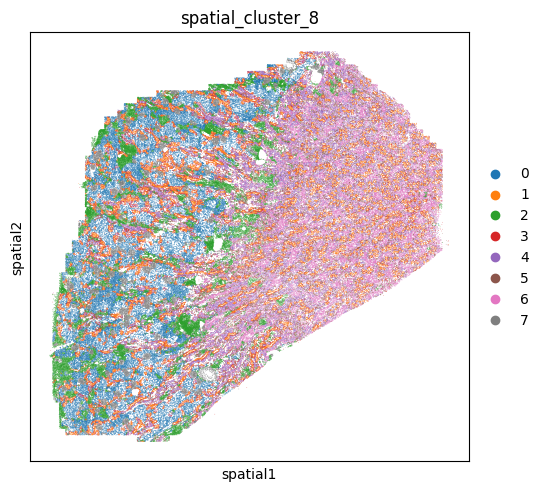

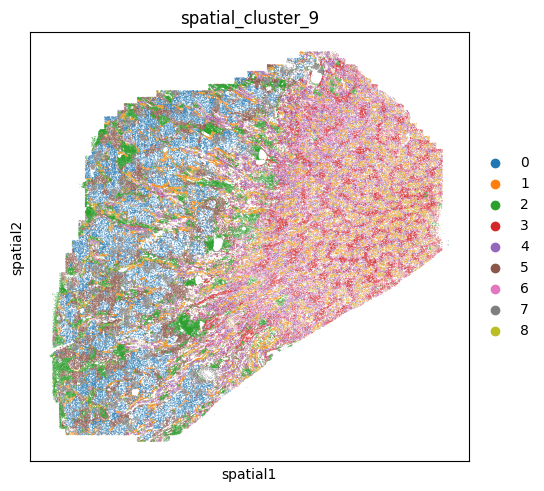

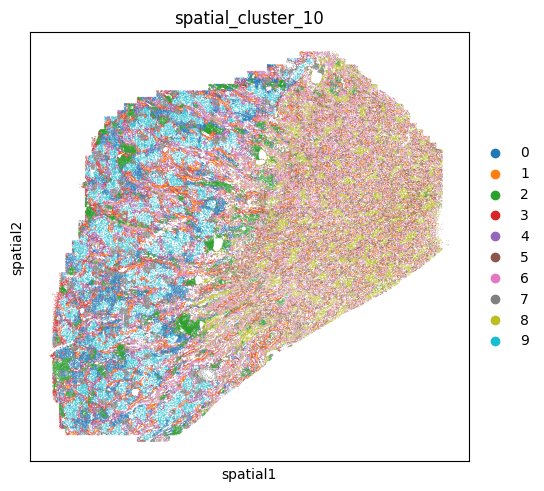

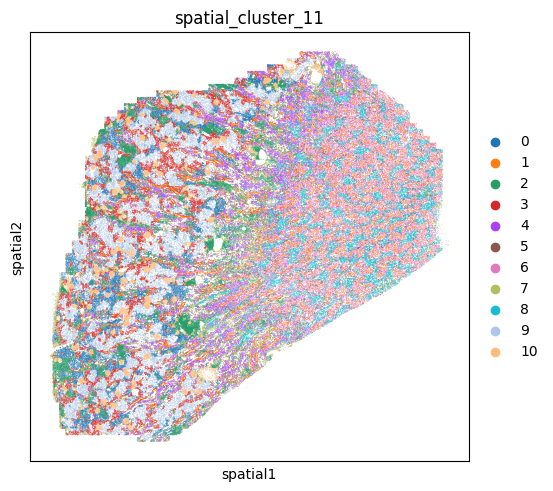

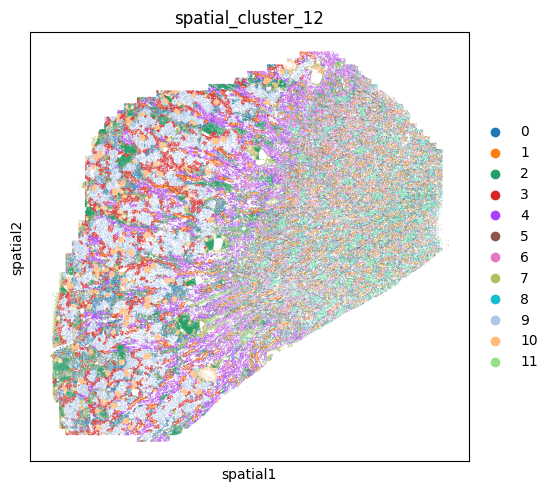

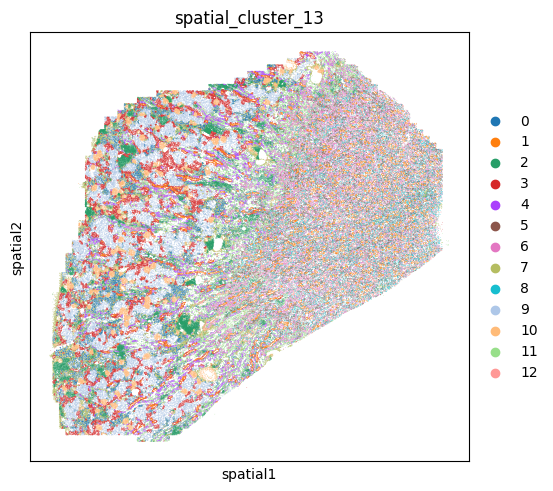

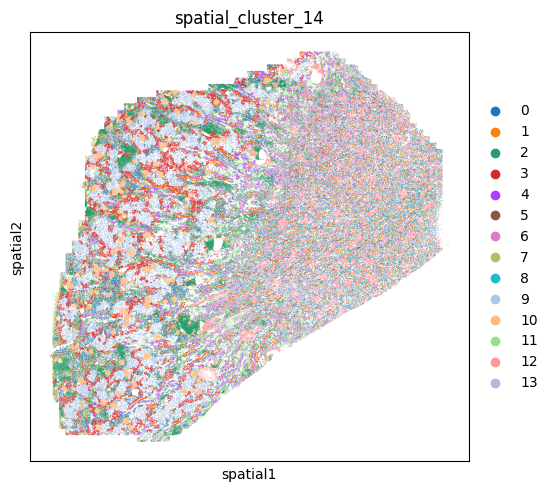

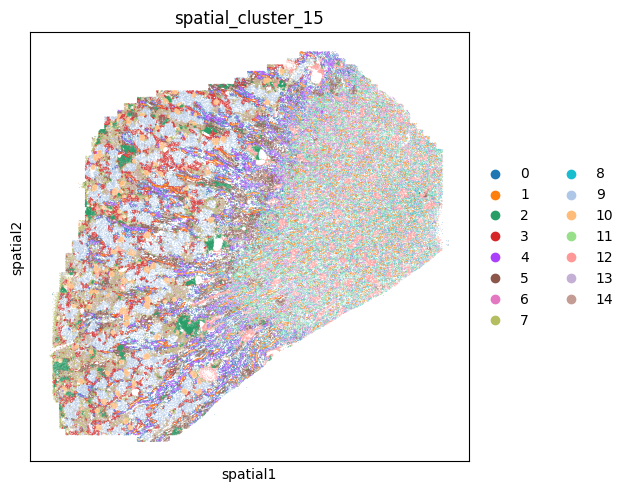

In [34]:
for i in range(6,16):
    gmm = cc.tl.Cluster(n_clusters=i, random_state=12345)
    gmm.fit(adata, use_rep='X_cellcharter')
    adata.obs[f'spatial_cluster_{i}'] = gmm.predict(adata, use_rep='X_cellcharter')
    sq.pl.spatial_scatter(adata, color=f'spatial_cluster_{i}', img=None, size=8, ncols=2)

In [35]:
adata

AnnData object with n_obs × n_vars = 410533 × 500
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'Cellbound2_raw', 'Cellbound2_high_pass', 'COLIII_raw', 'COLIII_high_pass', 'VIM_raw', 'VIM_high_pass', 'Cellbound3_raw', 'Cellbound3_high_pass', 'PolyT_raw', 'PolyT_high_pass', 'Cellbound1_raw', 'Cellbound1_high_pass', 'Anti-Human_raw', 'Anti-Human_high_pass', 'Beta-3-Tubulin_raw', 'Beta-3-Tubulin_high_pass', 'VCAM1_raw', 'VCAM1_high_pass', 'MPO_raw', 'MPO_high_pass', 'DAPI_raw', 'DAPI_high_pass', 'region', 'slide', 'dataset_id', 'cells_region', 'EntityID', 'n_counts', 'tacco', 'tacco_score', '_scvi_batch', '_scvi_labels', 'spatial_cluster_5', 'spatial_cluster_6', 'spatial_cluster_7', 'spatial_cluster_8', 'spatial_cluster_9', 'spatial_cluster_10', 'spatial_cluster_11', 'spatial_cluster_12', 'spatial_cluster_13', 'spatial_cluster_14', 'spatial_cluster_15'
    uns: 'spatialdata_attrs'

In [36]:
adata.write('cellcharter_15_clusters_kidney.h5ad')

In [37]:
adata

AnnData object with n_obs × n_vars = 410533 × 500
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'Cellbound2_raw', 'Cellbound2_high_pass', 'COLIII_raw', 'COLIII_high_pass', 'VIM_raw', 'VIM_high_pass', 'Cellbound3_raw', 'Cellbound3_high_pass', 'PolyT_raw', 'PolyT_high_pass', 'Cellbound1_raw', 'Cellbound1_high_pass', 'Anti-Human_raw', 'Anti-Human_high_pass', 'Beta-3-Tubulin_raw', 'Beta-3-Tubulin_high_pass', 'VCAM1_raw', 'VCAM1_high_pass', 'MPO_raw', 'MPO_high_pass', 'DAPI_raw', 'DAPI_high_pass', 'region', 'slide', 'dataset_id', 'cells_region', 'EntityID', 'n_counts', 'tacco', 'tacco_score', '_scvi_batch', '_scvi_labels', 'spatial_cluster_5', 'spatial_cluster_6', 'spatial_cluster_7', 'spatial_cluster_8', 'spatial_cluster_9', 'spatial_cluster_10', 'spatial_cluster_11', 'spatial_cluster_12', 'spatial_cluster_13', 'spatial_cluster_14', 'spatial_cluster_15'
    uns: 'spatialdata_attrs'

In [38]:
obs_df = adata.obs

In [39]:
obs_df.to_csv('obs_data_15_clusters_kidney.csv')